# Simulación de ceniza volcánica: Modelo 3D y mapa de riesgo

## 1. Contexto y objetivos
En el notebook anterior (`01_prototipo_2D.ipynb`), desarrollamos un modelo físico funcional en 2D que simula la altura y distancia de las partículas (Vista de perfil).
Sin embargo, para evaluar el **riesgo volcánico real**, necesitamos responder: ¿Qué ciudades o zonas geográficas serán afectadas?

Este notebook expande la simulación a 3 Dimensiones ($x, y, z$) para obtener una vista aérea de la dispersión.

## 2. Cambios en el modelo físico
La física subyacente (Advección-Difusión) permanece idéntica, pero vectorizamos las ecuaciones para manejar tres coordenadas:
* **Eje $x$ (Longitudinal):** Dirección principal del viento (Este-Oeste).
* **Eje $y$ (Vertical):** Altura de la columna eruptiva y caída por gravedad.
* **Eje $z$ (Transversal):** Dispersión lateral (Norte-Sur).

### Ecuación Vectorial 3D
El estado de cada partícula ahora está definido por un vector $\vec{r} = (x, y, z)$. La evolución sigue la ecuación de Langevin:

$$\vec{r}_{t+1} = \vec{r}_t + \underbrace{\vec{V}(y) \cdot \Delta t}_{\text{Viento + Gravedad}} + \underbrace{\sqrt{2D\Delta t} \cdot \vec{\xi}}_{\text{Difusión Isotrópica}}$$

**Nota sobre la difusión en $z$:**
Aunque asumiremos inicialmente que el viento en $z$ es cero ($v_z = 0$), la nube se ensanchará lateralmente debido al término estocástico ($\vec{\xi}$). Esto simula cómo la turbulencia atmosférica dispersa la ceniza en todas direcciones, creando una forma de "abanico" o pluma cónica vista desde arriba.

### 3. Escala realista
A diferencia del prototipo anterior, aquí simularemos una erupción a escala real:
* **Distancias:** Kilómetros (no metros).
* **Masa:** Toneladas de ceniza.
* **Tiempo:** Horas de erupción.

El objetivo final es transformar puntos dispersos en un **mapa de riesgo** interpretable para la toma de decisiones.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib import colors

# --- 1. CONFIGURACIÓN DEL ESCENARIO (Datos Reales) ---
# Escala de Simulación
N_PARTICULAS = 50000      # Alta resolución (Block 1)
DT = 10.0                 # Paso de tiempo en segundos (Block 1)
TIEMPO_HORAS = 4          # Duración total (Block 1)
TIEMPO_PASOS = int(TIEMPO_HORAS * 3600 / DT)

# Física del Volcán
MASA_TOTAL_KG = 4.0e10     # 500 Millones de kg (Block 1)
ALTURA_COLUMNA = 10000.0   # 6 km de altura (Block 1)
D = 600.0                # Difusión/Turbulencia (Block 1)

# Inicialización
# Array de (N, 3). Columna 0=X, 1=Y, 2=Z
posiciones = np.zeros((N_PARTICULAS, 3))
posiciones[:, 1] = ALTURA_COLUMNA # Todas inician arriba

# Emisión continua durante la primera hora (3600s)
tiempos_nacimiento = np.linspace(0, 3600, N_PARTICULAS) 
en_suelo = np.zeros(N_PARTICULAS, dtype=bool)

# --- 2. FUNCIÓN DE FÍSICA (Estructura del Block 2) ---
def obtener_viento(pos_array):
    """
    Calcula la velocidad del viento en 3D para cada partícula.
    Adapta la cizalladura a la escala de 6km.
    """
    alturas = pos_array[:, 1] # Columna Y
    
    # EJE X: Viento con Cizalladura (Variable con altura)
    # En el suelo (y=0) -> viento=0
    # En la cima (y=6000) -> viento=25 m/s
    vx = 15.0 * (alturas / ALTURA_COLUMNA)
    
    # EJE Y: Gravedad
    # Caen a 2 m/s (Ceniza gruesa/lapilli)
    vy = np.full(len(alturas), -2.0)
    
    # EJE Z: Sin viento lateral
    # (La dispersión lateral vendrá solo del término de difusión/ruido)
    vz = np.zeros(len(alturas))
    
    return np.column_stack((vx, vy, vz))

# --- 3. BUCLE DE SIMULACIÓN ---
print(f"Iniciando simulación híbrida: {TIEMPO_HORAS} horas con física 3D...")

for t in range(TIEMPO_PASOS):
    t_actual = t * DT
    
    # Filtro: Solo partículas que ya nacieron y siguen volando
    activas = (tiempos_nacimiento <= t_actual) & (~en_suelo)
    
    if np.sum(activas) > 0:
        p_activas = posiciones[activas]
        
        # A. Advección (Usando la función del Block 2)
        viento = obtener_viento(p_activas)
        
        # B. Difusión (Turbulencia aleatoria en X, Y, Z)
        ruido = np.random.normal(0, np.sqrt(2 * D * DT), size=p_activas.shape)
        
        # C. Integración (Euler)
        desplazamiento = (viento * DT) + ruido
        posiciones[activas] += desplazamiento
        
        # D. Condiciones de Frontera (Suelo)
        # Chequeamos si bajaron de 0 en el eje Y
        suelo_mask = (posiciones[:, 1] <= 0) & activas
        
        # Las "pegamos" al suelo
        posiciones[suelo_mask, 1] = 0.0 
        en_suelo[suelo_mask] = True

print("✅ Simulación terminada. Datos listos para graficar.")

Iniciando simulación híbrida: 4 horas con física 3D...
✅ Simulación terminada. Datos listos para graficar.


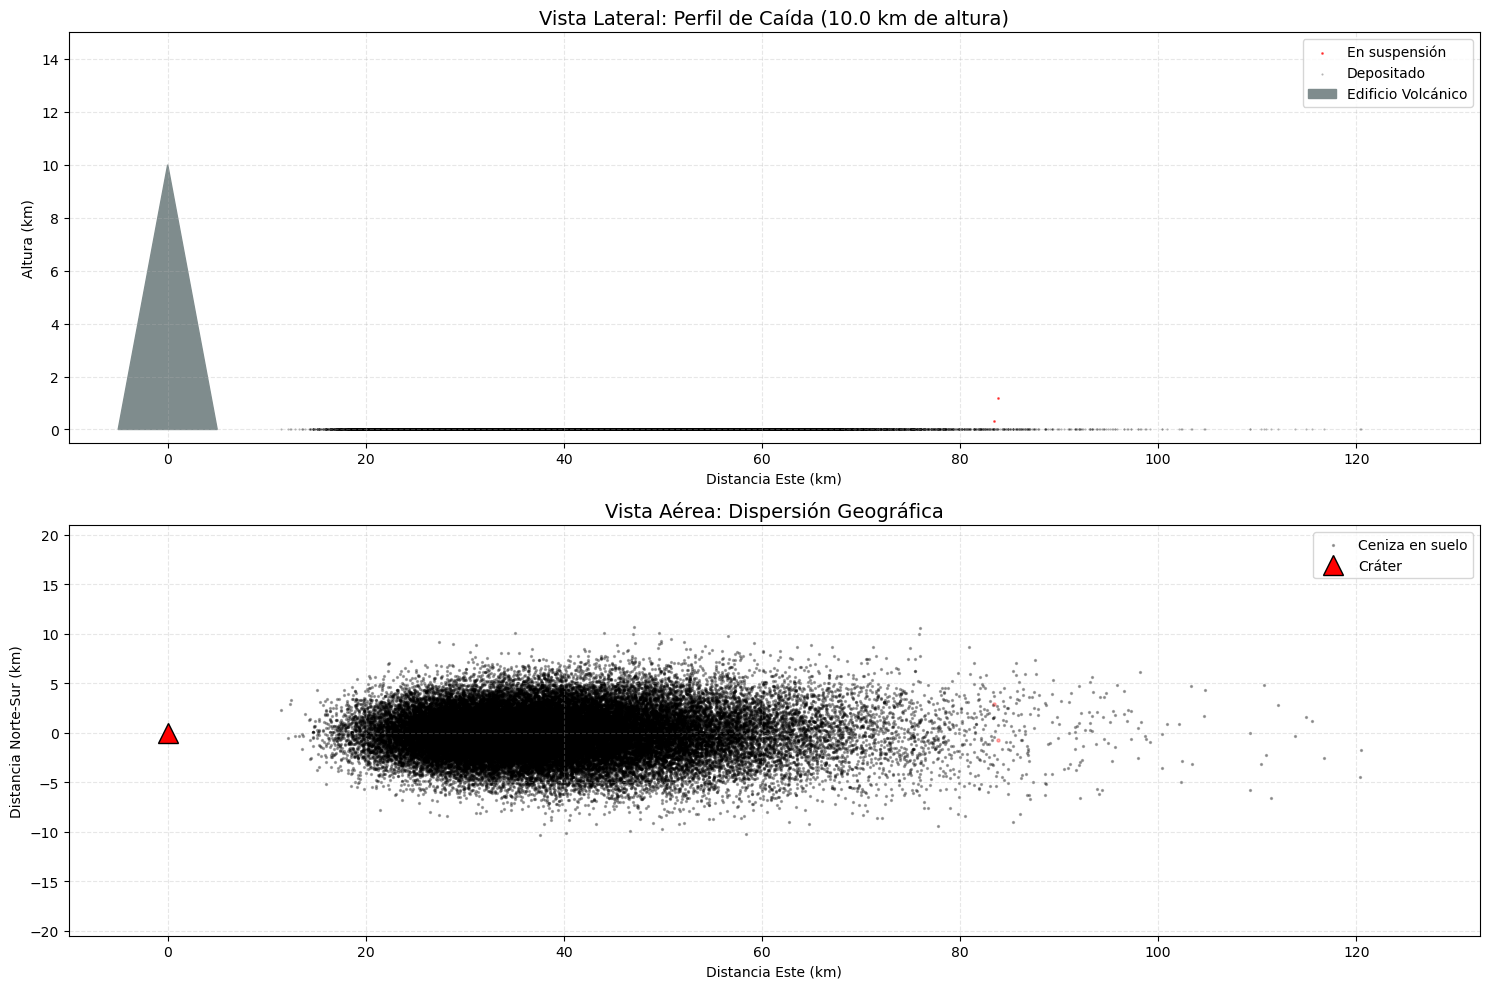

In [27]:
# --- VISUALIZACIÓN DE GEOMETRÍA (Estética Mejorada) ---
plt.figure(figsize=(15, 10))

# Conversión de metros a Kilómetros para lectura fácil
x_km = posiciones[:, 0] / 1000
y_km = posiciones[:, 1] / 1000
z_km = posiciones[:, 2] / 1000
altura_volcan_km = ALTURA_COLUMNA / 1000

# --- PANEL 1: VISTA DE PERFIL (Lateral) ---
plt.subplot(2, 1, 1)
plt.title(f"Vista Lateral: Perfil de Caída ({altura_volcan_km} km de altura)", fontsize=14)

# 1. Dibujamos la Ceniza
# Nube en aire (Rojo) - Usamos s=10 para que se noten si quedan pocas
plt.scatter(x_km[~en_suelo], y_km[~en_suelo], c='red', s=1, alpha=0.6, label='En suspensión')
# Ceniza en suelo (Negro)
plt.scatter(x_km[en_suelo], y_km[en_suelo], c='black', s=1, alpha=0.3, marker='.', label='Depositado')

# 2. Dibujamos el Volcán (Más estético)
# Base ancha de 10km (-5 a 5) para que parezca montaña, no aguja
plt.fill([-5, 0, 5], [0, altura_volcan_km, 0], color='#7f8c8d', label='Edificio Volcánico') 

# Detalles del gráfico
plt.ylabel("Altura (km)")
plt.xlabel("Distancia Este (km)")
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.3)

# Límites inteligentes (Para que el volcán no se vea aplastado)
plt.ylim(-0.5, altura_volcan_km * 1.5) 
plt.xlim(-10, np.max(x_km) * 1.1)


# --- PANEL 2: VISTA AÉREA (Mapa) ---
plt.subplot(2, 1, 2) 
plt.title("Vista Aérea: Dispersión Geográfica", fontsize=14)

# 1. Ceniza
plt.scatter(x_km[~en_suelo], z_km[~en_suelo], c='red', s=5, alpha=0.3)
plt.scatter(x_km[en_suelo], z_km[en_suelo], c='black', s=2, alpha=0.3, label='Ceniza en suelo')

# 2. Volcán (Triángulo rojo visto desde arriba)
plt.plot(0, 0, 'r^', markersize=15, markeredgecolor='k', label='Cráter') 

# Detalles
plt.ylabel("Distancia Norte-Sur (km)")
plt.xlabel("Distancia Este (km)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.axis('equal') # CLAVE: Mantiene la proporción real del terreno

# Límites dinámicos
plt.xlim(-10, np.max(x_km) * 1.1)
plt.ylim(np.min(z_km)*1.2, np.max(z_km)*1.2) # Centrado en la pluma

plt.tight_layout()
plt.show()

## Procesamiento de datos: Transformación Lagrangiana a Euleriana

Hasta este punto, nuestra simulación ha sido **Lagrangiana**: hemos rastreado la trayectoria individual de cada partícula ($\vec{r}_i$). Sin embargo, para evaluar el riesgo en una ciudad o zona de cultivo, no nos interesa saber "dónde está la partícula, sino "cuánta masa total cayó en este kilómetro cuadrado".

Para lograr esto, realizamos una transformación a un enfoque **Euleriano** (basado en una rejilla fija):

1.  **Discretización (Binning):** Dividimos el terreno en una cuadrícula de celdas de tamaño fijo (ej. $1 \times 1$ km).
2.  **Agregación:** Sumamos la masa de todas las partículas que cayeron dentro de cada celda usando un histograma 2D.
3.  **Cálculo de Carga:** Convertimos el conteo de partículas a densidad física ($kg/m^2$).

$$\text{Carga} (kg/m^2) = \frac{\text{Conteo en celda} \times \text{Masa por partícula}}{\text{Área de la celda}}$$

In [28]:
# --- PASO 3: PROCESAMIENTO CIENTÍFICO ---
# Objetivo: Convertir puntos dispersos (Lagrangiano) en una malla de densidad (Euleriano).

# 1. Extraer coordenadas de la ceniza en el suelo
x_suelo = posiciones[en_suelo, 0]
z_suelo = posiciones[en_suelo, 2]

# 2. Definir la "Hoja de Papel" (La Rejilla)
# Queremos un mapa de 100km x 40km
RANGO_X = [0, 100000]     
RANGO_Z = [-20000, 20000] 
BINS = 100 # Resolución de 100x100 cuadros

# 3. El Histograma 2D (Aquí ocurre la magia de "puntos a densidad")
conteo, _, _ = np.histogram2d(x_suelo, z_suelo, bins=BINS, range=[RANGO_X, RANGO_Z])

# 4. Convertir a Unidades Reales (kg/m^2)
masa_por_particula = MASA_TOTAL_KG / N_PARTICULAS
area_celda = ((RANGO_X[1]-RANGO_X[0])/BINS) * ((RANGO_Z[1]-RANGO_Z[0])/BINS)
mapa_crudo = (conteo * masa_por_particula) / area_celda

# 5. Corrección Estadística (Filtro Gaussiano)
# Responde a tu duda: Se aplica AQUÍ, antes de graficar.
# Convierte el ruido pixelado en una nube continua realista.
mapa_suave = gaussian_filter(mapa_crudo, sigma=1.5)

print("Matriz de densidad calculada y suavizada.")

print(f"Carga MÁXIMA detectada: {np.max(mapa_suave):.2f} kg/m^2")


Matriz de densidad calculada y suavizada.
Carga MÁXIMA detectada: 246.58 kg/m^2


### Corrección estadística: Estimación de densidad (KDE)

Al proyectar un número finito de partículas (30,000) sobre una cuadrícula extensa, es normal encontrar ruido de muestreo":
* Celdas vacías adyacentes a celdas con mucha masa.
* Picos artificiales de acumulación debido al azar.

En la realidad, una nube de ceniza es un medio continuo, no un conjunto de puntos discretos. Para recuperar la continuidad física y mitigar el error de muestreo, aplicamos un filtro gaussiano (`Gaussian Filter`).

> **Nota Técnica:** Esto actúa como una *Kernel Density Estimation (KDE)* simplificada. Matemáticamente, redistribuye la masa de cada celda hacia sus vecinas basándose en una distribución normal, suavizando los artefactos numéricos sin alterar la masa total del sistema.

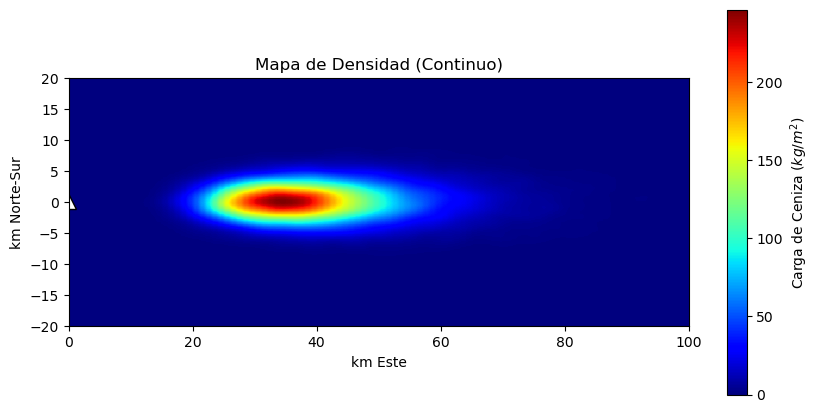

In [29]:
# --- PASO 4: VISUALIZACIÓN CONTINUA (Mapa de Calor) ---
# ¿Para qué sirve? Para ver gradientes y la dirección del viento.

plt.figure(figsize=(10, 5))

# Usamos 'inferno' o 'magma' para resaltar la intensidad
plt.imshow(mapa_suave.T, origin='lower', cmap='jet', 
           extent=[RANGO_X[0]/1000, RANGO_X[1]/1000, RANGO_Z[0]/1000, RANGO_Z[1]/1000])

plt.colorbar(label='Carga de Ceniza ($kg/m^2$)')
plt.plot(0, 0, 'w^', markersize=10, markeredgecolor='k', label='Volcán')
plt.title("Mapa de Densidad (Continuo)")
plt.xlabel("km Este")
plt.ylabel("km Norte-Sur")
plt.show()

## 3. Clasificación del Riesgo (Impacto Real)

El mapa anterior nos muestra *dónde* hay ceniza, pero no nos dice qué tan grave es. En gestión de riesgos, se utlizan umbrales específicos para tomar decisiones.

Basándonos en estándares vulcanológicos (ej. USGS), clasificamos la acumulación en **4 Zonas de Impacto**:

| Zona (Color) | Carga ($kg/m^2$) | Impacto Esperado |
| :--- | :--- | :--- |
| **Verde** | 1 - 10 | **Molestia:** Aeropuertos cerrados, limpieza necesaria. |
| **Amarillo** | 10 - 100 | **Daño Económico:** Pérdida de cultivos, daño a motores. |
| **Naranja** | 100 - 300 | **Daño Estructural:** Riesgo para techos débiles. |
| **Rojo** | > 300 | **Colapso:** Destrucción de techos, peligro mortal. |

A continuación, convertimos nuestro gradiente continuo en un **Mapa de Zonas Discretas**.

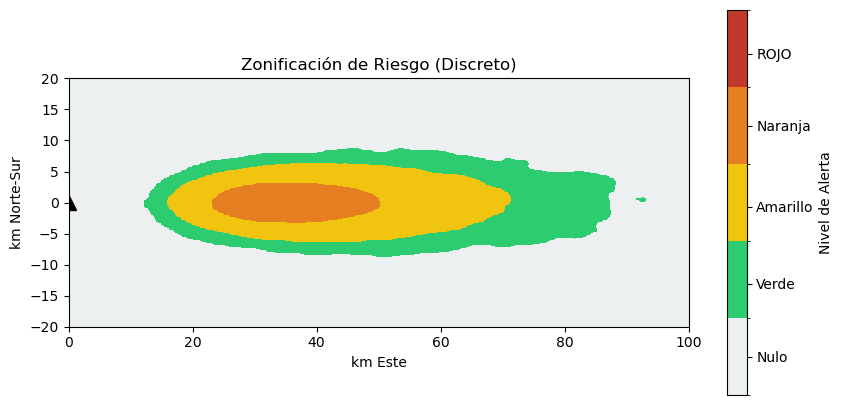

In [30]:
# --- PASO 5: VISUALIZACIÓN DISCRETA (Mapa de Riesgo) ---
# ¿Para qué sirve? Para tomar decisiones (Evacuar o no).

plt.figure(figsize=(10, 5))

# Definimos los cortes exactos de la tabla
niveles = [0, 1, 10, 100, 300, 1000]
colores = ['#ecf0f1', '#2ecc71', '#f1c40f', '#e67e22', '#c0392b'] # Gris, Verde, Amarillo, Naranja, Rojo
cmap_riesgo = colors.ListedColormap(colores)
norma = colors.BoundaryNorm(niveles, cmap_riesgo.N)

plt.imshow(mapa_suave.T, origin='lower', 
           extent=[RANGO_X[0]/1000, RANGO_X[1]/1000, RANGO_Z[0]/1000, RANGO_Z[1]/1000],
           cmap=cmap_riesgo, norm=norma)

cbar = plt.colorbar(label='Nivel de Alerta')
cbar.set_ticks([0.5, 5, 50, 200, 600])
cbar.set_ticklabels(['Nulo', 'Verde', 'Amarillo', 'Naranja', 'ROJO'])

plt.plot(0, 0, 'k^', markersize=10, label='Volcán')
plt.title("Zonificación de Riesgo (Discreto)")
plt.xlabel("km Este")
plt.ylabel("km Norte-Sur")
plt.show()

# Conclusiones y próximos pasos

## Resumen del proyecto
En este notebook, hemos logrado escalar un modelo físico simple (Langevin 2D) a una herramienta de simulación geoespacial completa. Hemos conseguido:
1.  **Simular la física:** Reproducir el transporte de ceniza volcánica bajo efectos de advección (viento) y difusión (turbulencia).
2.  **Procesar datos:** Transformar trayectorias de partículas individuales en mapas de densidad de carga ($kg/m^2$).
3.  **Evaluar riesgo:** Aplicar umbrales internacionales (USGS) para identificar zonas de colapso estructural y daño económico.

## Limitaciones del Modelo
Aunque los resultados son visualmente coherentes, este modelo asume:
* **Viento constante:** En la realidad, el viento cambia de dirección con el tiempo y la altura (perfiles de viento complejos).
* **Topografía plana:** No consideramos montañas que podrían bloquear la ceniza.
* **Partícula única:** Asumimos un tamaño de partícula promedio, cuando en realidad hay una distribución granulométrica.

Para convertir esto en un producto de producción real, los siguientes pasos serían:
* Integrar datos meteorológicos reales (API de vientos NOAA).
* Superponer los resultados en un mapa real (usando librerías como `Folium` o `GeoPandas`).